
## Mixture Density Networks

This technique was proposed by Christopher M. Bishop in 1994. It is a type of PDF shaping regression technique using gaussian distributions only. 

The paper: https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf



In [19]:
##############################################################
## 
## Mixture Density Networks (MDN)
##
## 2022
## 
##############################################################

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader


###############################################################

N_EPOCHS = 2000    ## 500
batch_size = 5  ## 50
learning_rate = 1e-5     ## 0.0003
sigma_0 = 0.1
samples = 50
display_step = 50

###############################################################



## The Probability Density Function of the Normal Distribution

<br/>

<center>
    
$ \large p(x) = \frac{1}{\sqrt{2 \pi \sigma ^2}} e^{- \frac{(x - \mu)^2}{2 \sigma ^2}} $
    
</center>

<br/>

0.00047618456635471507
0.0026706310799552713
[0.04965552 0.09931105 0.09931105 0.44689972 0.49655524 1.14207706
 1.24138811 2.13518755 2.33380965 2.08553203 3.17795357 2.4331207
 3.17795357 3.47588671 3.97244196 3.37657566 3.67450881 3.22760909
 3.37657566 2.73105385 2.13518755 1.29104364 1.04276601 0.59586629
 0.94345496 0.29793315 0.34758867 0.09931105 0.09931105 0.04965552]
[-0.2920353  -0.27189655 -0.2517578  -0.23161906 -0.21148031 -0.19134157
 -0.17120282 -0.15106407 -0.13092533 -0.11078658 -0.09064783 -0.07050909
 -0.05037034 -0.0302316  -0.01009285  0.0100459   0.03018464  0.05032339
  0.07046213  0.09060088  0.11073963  0.13087837  0.15101712  0.17115586
  0.19129461  0.21143336  0.2315721   0.25171085  0.2718496   0.29198834
  0.31212709]
(31,)


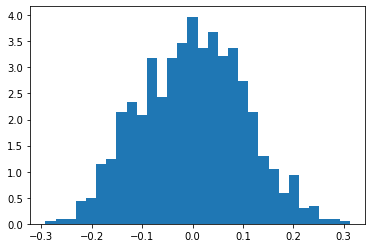

In [20]:


mu_rc    = 0         ## zero mean
sigma_rc = 0.1       ## standard deviation

s_rc = np.random.normal(mu_rc, sigma_rc, 1000)

## verify the mean and variance

print(  abs(mu_rc     -  np.mean(s_rc))  )
print(  abs(sigma_rc  -  np.std(s_rc, ddof=1)))


## Display the histogram of the samples, and the PDF function

count, bins, ignored = plt.hist(s_rc, 30, density=True)

print(count)
print(bins)
print(bins.shape)


In [21]:

def gaussian_pdf(x):
    return 1/(sigma_rc * np.sqrt(2 * np.pi)) * np.exp( - (x - mu_rc)**2 / (2 * sigma_rc**2))


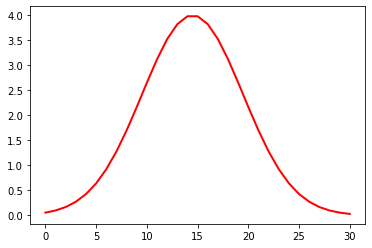

In [22]:

plt.plot(gaussian_pdf(bins), linewidth=2, color='r')


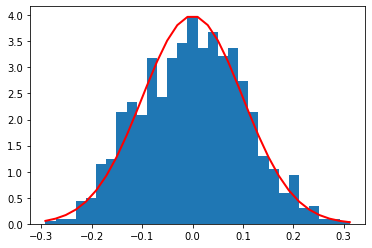

In [23]:

count, bins, ignored = plt.hist(s_rc, 30, density=True)
plt.plot(bins, gaussian_pdf(bins), linewidth=2, color='r')
plt.show()


## Functions for data with quadratic shape and Normally distributed error

In [24]:

###############################################################
## quadratic function

def f(x):
    return x**2-6*x+9 

###############################################################
## This function generates quadratic data perturbed with error
## which follows a normal distribution
## the sigma*x is what increases the standard deviation of the 
## error proportionally as x grows


def data_generator(x, sigma_0, samples):
    ##                      mean     standard dev      
    return np.random.normal(f(x),    sigma_0*x,     samples)

###############################################################


## Data x for quadratic curve

In [25]:

x_vals = np.arange(1, 5.2, 0.2)
print(x_vals)


[1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4
 4.6 4.8 5. ]


## Data points from g(x) for scatter

The g(x) function is made up of f(x) and the error. This process is done in the following for loop. 

$  \large g(x) = f(x) + \epsilon  $

In [26]:


x_arr = np.array([])
y_arr = np.array([])


for x in x_vals:
    ## for every sample in x_vals, generate n=50 normally distributed
    ## samples for y_arr
    x_arr = np.append(    x_arr,   np.full(samples, x)                       )
    y_arr = np.append(    y_arr,   data_generator(x, sigma_0, samples)       )

    
x_arr, y_arr   =   shuffle(x_arr, y_arr)

print(x_arr)
print(y_arr)
print(x_arr.shape)
print(y_arr.shape)



[5.  2.2 3.2 ... 1.  2.8 3. ]
[ 3.66242059  0.37777937  0.39118512 ...  3.95975721  0.08402429
 -0.35637834]
(1050,)
(1050,)


## Plot the g(x) function



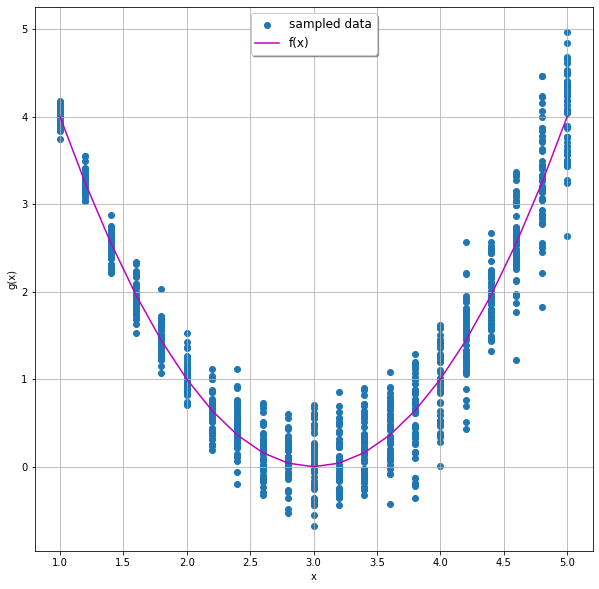

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')

ax.scatter(x_arr,y_arr,label='sampled data')

ax.plot( x_vals, list(map(f,x_vals)), c='m', label='f(x)')

ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Convert train data to pyTorch

In [28]:


inputs  = x_arr
targets = y_arr

## make into column vectors
inputs  = inputs.reshape((-1, 1))
targets = targets.reshape((-1, 1))

## fix data type
inputs  = inputs.astype(np.float32)
targets = targets.astype(np.float32)

## convert to torch tensors
inputs  = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

print(inputs)
print(targets)



tensor([[5.0000],
        [2.2000],
        [3.2000],
        ...,
        [1.0000],
        [2.8000],
        [3.0000]])
tensor([[ 3.6624],
        [ 0.3778],
        [ 0.3912],
        ...,
        [ 3.9598],
        [ 0.0840],
        [-0.3564]])


## Create Torch DataLoader

In [29]:
#####################################################################
## define dataset

train_ds = TensorDataset(inputs, targets)

print(  train_ds[0:3]  )
    
#####################################################################
## define dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

print(    next(iter(train_dl))   )


####################################################################

(tensor([[5.0000],
        [2.2000],
        [3.2000]]), tensor([[3.6624],
        [0.3778],
        [0.3912]]))
[tensor([[5.0000],
        [5.0000],
        [1.6000],
        [4.2000],
        [2.4000]]), tensor([[4.0872],
        [4.0587],
        [1.8259],
        [1.6621],
        [0.1493]])]


## Fit a deep learning regression network to the g(x) data

In [30]:

#####################################################################

def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss:', loss_fn(model(inputs), targets))
    

#####################################################################
## starts fitting after 1000 iterations
## use Tanh or sigmoid ?? 

class DL_Net(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()             ## nn.ReLU()
        self.linear2 = nn.Linear(12, 12)
        self.act2    = nn.Tanh() 
        self.linear3 = nn.Linear(12, 1)
         
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x = self.linear3(x)
        return x
    
#######################################################
## Does not fit using ReLU! Why ??

class SimpleNet(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()
        self.linear2 = nn.Linear(12, 1)
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x
    
    
#############################################################

model   = DL_Net()    ## 5000 epochs to get a better fit
## model   = SimpleNet()
## opt     = torch.optim.SGD(   model.parameters(), lr=learning_rate   )
opt        = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = F.mse_loss

#############################################################

fit(N_EPOCHS, model, loss_fn, opt)

preds = model(inputs)

print(preds)
print(targets)

#############################################################



Training loss: tensor(0.1505, grad_fn=<MseLossBackward0>)
tensor([[ 3.3953],
        [ 0.5389],
        [ 0.0951],
        ...,
        [ 3.8605],
        [-0.0607],
        [-0.0325]], grad_fn=<AddmmBackward0>)
tensor([[ 3.6624],
        [ 0.3778],
        [ 0.3912],
        ...,
        [ 3.9598],
        [ 0.0840],
        [-0.3564]])


## Generate Test x data, and use model to predict

In [31]:

x_test_orig         =   np.arange( 1.1, 5.1, 0.2)

'''

x_test_oversampled = np.array([])

for x in x_test_orig:
    ## for every sample in x_test_orig, generate n=50 copies
    x_test_oversampled = np.append(    x_test_oversampled,   np.full(samples, x)                       )

print(x_test_oversampled.shape)

'''

x_test = x_test_orig

x_test  = x_test.reshape((-1, 1))
x_test  = x_test.astype(np.float32)
x_test  = torch.from_numpy(x_test)

print(x_test)



tensor([[1.1000],
        [1.3000],
        [1.5000],
        [1.7000],
        [1.9000],
        [2.1000],
        [2.3000],
        [2.5000],
        [2.7000],
        [2.9000],
        [3.1000],
        [3.3000],
        [3.5000],
        [3.7000],
        [3.9000],
        [4.1000],
        [4.3000],
        [4.5000],
        [4.7000],
        [4.9000]])


## Use model to predict on test data

In [32]:

y_pred  = model(x_test)

print(y_pred)
print(targets)



tensor([[ 3.5918],
        [ 3.0044],
        [ 2.3850],
        [ 1.7763],
        [ 1.2174],
        [ 0.7399],
        [ 0.3656],
        [ 0.1065],
        [-0.0339],
        [-0.0598],
        [ 0.0197],
        [ 0.1918],
        [ 0.4418],
        [ 0.7544],
        [ 1.1147],
        [ 1.5085],
        [ 1.9233],
        [ 2.3480],
        [ 2.7730],
        [ 3.1910]], grad_fn=<AddmmBackward0>)
tensor([[ 3.6624],
        [ 0.3778],
        [ 0.3912],
        ...,
        [ 3.9598],
        [ 0.0840],
        [-0.3564]])


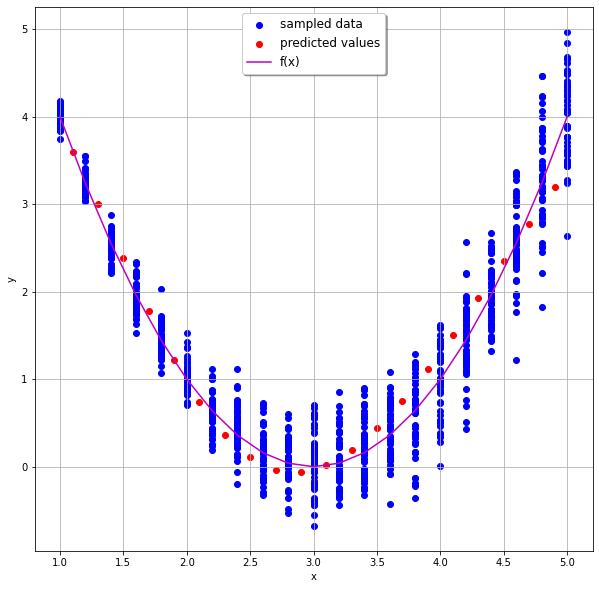

In [33]:


fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

ax.scatter(x_arr,y_arr,c='b',label='sampled data')

ax.scatter(x_test.detach().numpy() ,y_pred.detach().numpy() ,c='r',label='predicted values')

ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')

ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()



From the red dots, it seems our Neural Net only learned the f(x) part of g(x) and it completely ignored the $ \large \epsilon $ error normally distributed random variable. To convince yourself, try more test samples (> 1000) and it will always plot about the same set of red dots.

To address this issue Christopher Bishop proposed MDNs. 

## Now repeat with an MDN

In [34]:
#####################################################################


class MDN_Net(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 12)
        self.act1    = nn.Tanh()             
        self.linear2 = nn.Linear(12, 12)
        self.act2    = nn.Tanh() 
        self.mu      = nn.Linear(12, 1)
        self.sigma   = nn.Linear(12, 1)
        ## self.act_sig = lambda x: nn.ELU(x) + 1         ## gets rid of negative vals
         
    
    ## perform inference
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        x_mu    = self.mu(x)
        x_sigma = self.sigma(x)
        ## x_sigma = self.act_sig(x_sigma)
        ## e^x always positive which is required here for sigma
        x_sigma = torch.exp(x_sigma)                  
        return x_mu, x_sigma
    
######################################################################
    
'''

## scratch equations MDN loss

# Define Loss function

cte = 1.0 / np.sqrt(2.0 * np.pi)


def gaussian_distribution(y, mu, sigma):

    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * cte


def mdn_loss_fn(w, sigma, mu, y):

    result = gaussian_distribution(y, mu, sigma) * w
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)


'''
    
    
######################################################################

def mdn_loss(mu, sigma, y):
    dist = torch.distributions.Normal(loc=mu, scale=sigma)
    return torch.mean(-dist.log_prob(y))

######################################################################

def mdn_fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            pred_mu, pred_sigma = model(xb)
            loss = loss_fn(pred_mu, pred_sigma, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    pred_mu, pred_sigma = model(inputs)
    print('Training loss:', loss_fn(pred_mu, pred_sigma, targets))


######################################################################

model   = MDN_Net()    ## 5000 epochs to get a better fit
opt     = torch.optim.Adam(   model.parameters(), lr=learning_rate   )
loss_fn = mdn_loss

######################################################################

mdn_fit(N_EPOCHS, model, loss_fn, opt)

pred_mu, pred_sigma = model(inputs)

print(pred_mu)
print(pred_sigma)





Training loss: tensor(0.3995, grad_fn=<MeanBackward0>)
tensor([[2.3963],
        [0.5429],
        [0.3037],
        ...,
        [3.8677],
        [0.1348],
        [0.1869]], grad_fn=<AddmmBackward0>)
tensor([[1.1733],
        [0.2010],
        [0.3598],
        ...,
        [0.1821],
        [0.2777],
        [0.3153]], grad_fn=<ExpBackward0>)


## Test MDN on test set

In [35]:

pred_mu, pred_sigma = model(x_test)

print(pred_mu)
print(pred_sigma)


tensor([[3.5949],
        [2.9862],
        [2.3357],
        [1.7055],
        [1.1528],
        [0.7142],
        [0.4035],
        [0.2163],
        [0.1384],
        [0.1517],
        [0.2383],
        [0.3814],
        [0.5670],
        [0.7830],
        [1.0194],
        [1.2682],
        [1.5229],
        [1.7783],
        [2.0305],
        [2.2764]], grad_fn=<AddmmBackward0>)
tensor([[0.1799],
        [0.1757],
        [0.1735],
        [0.1750],
        [0.1814],
        [0.1931],
        [0.2103],
        [0.2329],
        [0.2613],
        [0.2957],
        [0.3366],
        [0.3849],
        [0.4411],
        [0.5062],
        [0.5807],
        [0.6652],
        [0.7600],
        [0.8654],
        [0.9811],
        [1.1068]], grad_fn=<ExpBackward0>)


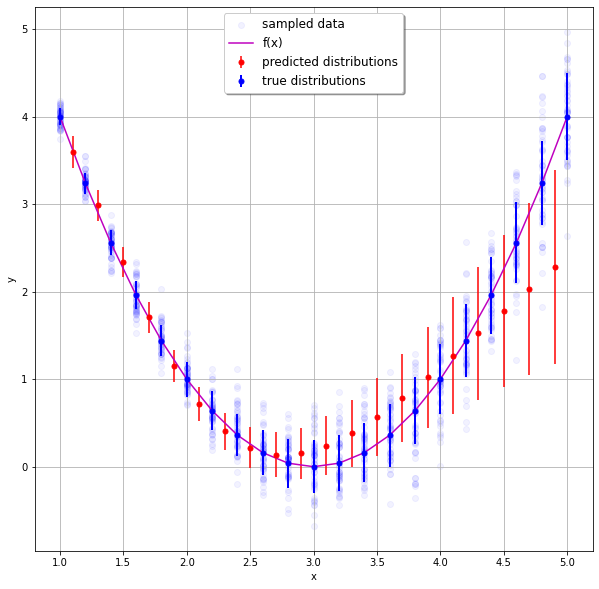

In [36]:
## print(x_test.detach().numpy().reshape((1, -1)))
## print(list(pred_mu.detach().numpy().reshape((1, -1))[0]))
## print( list(  np.absolute(   pred_sigma.detach().numpy().reshape((1, -1))[0]   )   ) )
## print(list(map(lambda x: sigma_0*x, x_vals)))

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')


ax.errorbar(x_test.detach().numpy().reshape((1, -1))[0], 
            list(pred_mu.detach().numpy().reshape((1, -1))[0]), 
            yerr=list(    np.absolute(   pred_sigma.detach().numpy().reshape((1, -1))[0]    )       ),
            c='r',
            ls='None',
            marker='.',
            ms=10,
            label='predicted distributions'
)
                                    
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')

ax.errorbar(x_vals,
            list(map(f,x_vals)),
            yerr=list(map(lambda x: sigma_0*x, x_vals)),
            c='b',
            lw=2,
            ls='None',
            marker='.',
            ms=10,
            label='true distributions'
)
                                


ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')


ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()


